In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
import plotly.express as px 
import pickle
import matplotlib.animation as animation
import kaleido 
import imageio
sys.path.insert(1, "../src/utils/")
from agent import Environment
from Q_learning import QLearningTrainer
sys.path.insert(1, "plotly_graph/")
from functions4tuto import plot_RL_2agents, plot_reward_rocket_2agents
JOSN_file = "rocket_tuto_3.json"

# <span style="color:orange">Goal</span>

The purpose of this tutorial is to land a rocket at a specific coordinate by adjusting its angle and booster power.
To control these variables effectively, we will use reinforcement learning to train the rocket to learn an optimal landing strategy through trial and error.

# <span style="color:orange">Intialize environment</span>

Create an environment object with the rules defined previously. The idea is to check the new field can raise a flag to stop simulation when the criteria are reached:

* 130 <= pos_x <= 150
* 0 <= pos_y <= 10
* -2 <= acceleration_y <= 2
* -10 <= speed_x >= 10 
* -10 <= speed_y >= 10 

We will also control the speed of the rocket and its acceleration to keep as possible those parameters between this range:

* -15 <= speed_x <= 15
* -15 <= speed_y <= 15
* -10 <= acceleration_x <= 10
* -10 <= acceleration_y <= 10

In [2]:
env = Environment(JOSN_file, check_model = True)
RL = QLearningTrainer(env, num_episodes = 2000, convergence_criterion = 0.5, 
                      decay_type = "exponential", decrease_prob_exp = 0.005)

check order names for states_variables

Check order names for agent_variables

check limit number of field

Check limit boundaries for initial state

Solve equations present in equations_variables field

Solve equations present in equations_rewards field

Everything is good :)


# <span style="color:orange">Rewards</span>

Before to use reinforcement learning. , let's first understand how the agent's reward and its individual components evolve. As a reminder. 

* The reward formula for the booster is:

$$  -2 * distance_{y\_reward} + speed_{y\_reward} + 0.5 * ratio_{fuel} $$

* The reward formula for the alpha (rocket's angle) is:

$$  -2 * distance_{x\_reward} + speed_{x\_reward} - 0.2* sin(angle) + 0.5 * ratio_{fuel} $$ 


where

* Distance reward: the ratio between the current distance to the target and the initial distance at time $t=0$. It reflects how far the rocket is from the landing target.
* speed reward: a penalty applied when the absolute speed (on a given axis) exceeds a threshold. The further the speed is from the desired range, the larger the penalty.
* angle: Penalty for the rocket's angular deviation from vertical.
* $ratio\_fuel$: normalized fuel quantity ($\frac{m\_fuel}{m\_fuel_{t=0}}$)


Fuel consumption depends on both booster and alpha agents:

* When the booster is activated: If the booster level is 1 or 2, fuel decreases by 5 or 10 units, respectively.

* When the rocket's alpha (lateral boosters that control rocket's angle) is not zero: An additional 5 units of fuel are consumed.

## <span style="color:orange">Reinforcemet learning</span>


After load our environment, next step is to create QLearningTrainer objet. It will apply Qlearning algorithm. For each states, the algorithm will apply a score base to the next iteration.

The Bellman equation is the value function use in reinforcement learning. 

$V(s,a) = V(s, a)+ \alpha * (R+\gamma * max(V(s', a')) - V(s, a))$

Where:

* $V(s, a)$ is the estimated value of state $s$ and actions $a$
* $s$ is the curent state
* $s'$ is the next state
* $a$ is action taken
* $a'$ next possible actions that maximize reward
* $R$ is the immediate reward received after transitioning
* $\gamma$ is the discount factor, which determines the importance of future rewards.
* $\alpha$ is the learning rate.

Different parameters are avaible. For the tutorial, you use default parameters. Before to lunch training. Lets discus about the input parameters.

### <span style="color:orange">Learning rate</span>


The learning rate $\alpha$ in the Bellman equation controls the weight given to the new estimate compared to the existing estimate of the state value. A smaller learning rate means that the new estimate has less influence, and the agent is more conservative in updating its value function. A larger learning rate allows the agent to adjust its estimates more rapidly based on new information

### <span style="color:orange">Discount factor (gamma)</span>

The discount factor $\gamma$, is a key hyperparameter that controls how much the agent values future rewards compared to immediate rewards. For rocket landing, $\gamma$ equal to 0.99, since we are optimizing over multiple steps to reach a safe landing.

### <span style="color:orange">Epsilon parameter</span>

Exploration-exploitation is a fundamental trade-off in reinforcement learning, where the agent needs to balance between exploring new actions and exploiting the knowledge it has gained so far.

The epsilon-greedy policy is a simple strategy that the agent uses to decide whether to explore a new action (random exploration) or exploit the current best-known action. It helps prevent the agent from getting stuck in suboptimal policies by occasionally trying new actions. The value of epsilon determines the probabilty the agent chooses a random action. A higher epsilon encourages more exploration, while a lower epsilon emphasizes exploitation of the current best-known actions.ent knowledge.

The epsilon parameter is decayed over time during training. This means that, as the agent gains more experience, it tends to rely more on exploitation and less on exploration. The idea is that, as the agent learns and becomes more confident in its estimates, it gradually reduces the rate of exploration. 

Epsilon initailization is made with the argument **exploration_prob**. It is a list with the lowest and the highest probability values. The probability will decrease with a rate given by the argument **decrease_prob_exp**. By default epsilon is modeled with a linear decay but you can change it to a exponential decay.


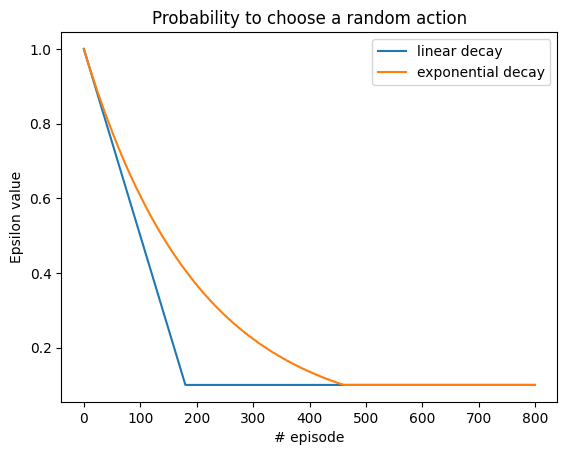

In [3]:
plt.plot(RL.get_epsilon(decay_type = 'linear')[0:800], label = "linear decay")
plt.plot(RL.get_epsilon(decay_type = 'exponential')[0:800], label = "exponential decay")
plt.title("Probability to choose a random action")
plt.legend()
plt.xlabel("# episode")
plt.ylabel("Epsilon value")
plt.show()

### <span style="color:orange">num_episodes, run_limit and convergence_criterion</span>

The last three options are hyperparameters that impact computation time:
* ``num_episodes``: The maximum number of training episodes.
* ``run_limit``: The maximum number of iterations allowed within a single episode before it is forcefully stopped.
* ``convergence_criterion``: The threshold used to determine convergence, based on the difference in Q-values between two iterations.


Before launching the training, it's important to understand that the Q-learning algorithm operates in a discretized space.
The spacing between bins can significantly impact convergence. If a discretized bin groups together too many different underlying states, the Q-table may become unstable, making it difficult for the algorithm to converge.

Let's examine how our space is discretized using ``RL.env.json["limit"]``.
The agents variable (booster and alpha) have 3 bins, while the state variables "pos_x", "pos_y", "angle", "speed_x", "speed_y", "weight_rocket" have 61, 81, 3, 13, 13, and 62 bins, respectively.

This results in a Q-table with:
Our Q table is composed of $$ 3 * 3 * 61 * 81 * 3 * 13 * 13 * 62 = 1.4 *10^9\  states $$

Does that mean our system will visit every possible state?
Of course not. Remember, the Q-learning algorithm starts with a random exploration (a random walk), but over time, the agent’s exploration becomes guided by what it has already experienced.
As a result, some states may never be visited if the agent never finds a path leading to them or if they are not useful for improving the policy.

# <span style="color:orange">Training</span>

You can also load a pre-trained RL object (trained ouput are stored in ``saved_model/output_train_2agents.txt``). If you want to generate the model from scratch, start training with the command: ``RL.q_learning()``. Before to lunch it, note it will take around 40-50 min to execute 2000 episodes.

In [4]:
with open('saved_model/RL_2agents.pkl', 'rb') as f:
    RL = pickle.load(f)

In [5]:
# RL.q_learning()
# #save model
# with open('saved_model/RL_2agents.pkl', 'wb') as f:  # open a text file
#     pickle.dump(RL, f)

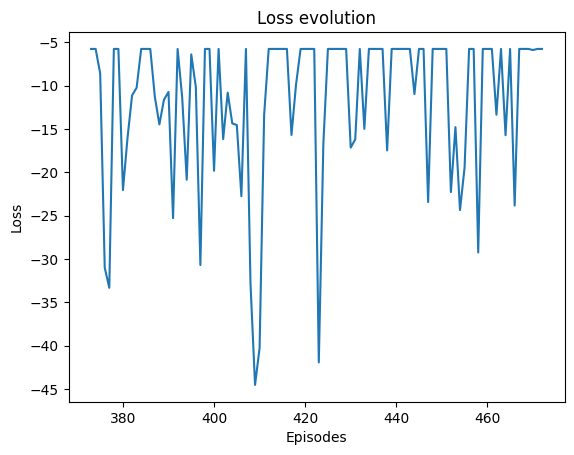

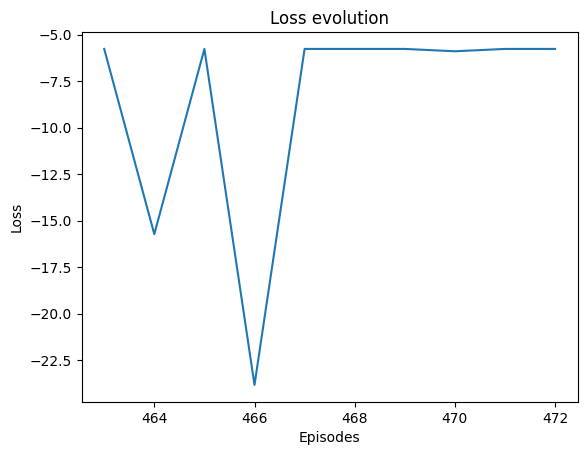

In [6]:
RL.plot_convergence(len(RL.loss_episodes) -100)
RL.plot_convergence(len(RL.loss_episodes) -10)

If you loaded the pre-trained model, you'll see that training stopped at episode 677. For the last five iterations the difference between $Qtable_N - Qtable_{N-1}$ remained bellow the convergence threshold (convergence_criterion = 0.5), indicating that the learning process had stabilized.

Let’s find out how many states we actually explored.
To do this, we replace Q-table values equal to 0 with np.nan.
(Except for goal-reaching states in our setup, a value of 0 typically means the state was never explored.)

In [7]:
states_explored = np.sum(RL.q_table.copy().replace(0, np.nan).count())

print("Number of states explored {0}.\
 Only {1:.5f}% states have been visited".format(
    states_explored,
    states_explored/1397838546 *100))

Number of states explored 1256. Only 0.00009% states have been visited


# <span style="color:orange">Optimal trajectory</span>

Let’s see how the rocket evolves after training.
We start by copying the Q-table using the ``q_table`` attribute, and we replace all 0 values with ``np.nan`` to better visualize learned values.

Next, we load a new environment and use its current discretized state as the starting point.
At each iteration, we follow the action suggested by the Q-table based on the environment’s current discretized state, which is updated after every step. At the end, we save all the states visited into a data frame (dt)

In [8]:
# load policy table
policy = RL.q_table.copy().replace(0, np.nan)
# load environnment
env = Environment(JOSN_file, check_model = False)
state = env.state_for_q_table()
flag_continue = True
while flag_continue:
    # control while loop
    if not policy.index.isin([str(state)]).any():
        flag_continue = False
        print("stop: no moore state")
        env.delete_last_states()
        continue
    elif env.pos_y[-1] >= 0 and env.pos_y[-1] <= 10 and env.pos_x[-1] >= 110 and env.pos_x[-1] <= 125:
        print("stop: reach goal")
        # env.delete_last_states()
        flag_continue = False
        continue
    else:
        action = RL.call_choose_action(state, 0)
        _, rewards, done, problem, info = env.step(action)
        state = env.state_for_q_table()

dt = pd.DataFrame(env.all_states())

stop episode because agent reach goal
stop: no moore state


## <span style="color:orange">Rocket Trajectory</span>

As we can see, the rocket reaches the ground slowly. Its trajectory appears more linear, and if we look at the speed profile, the reinforcement learning model keeps the speed and acceleration within the desired limit of [-10, 10].

In [9]:
plot_RL_2agents(dt)

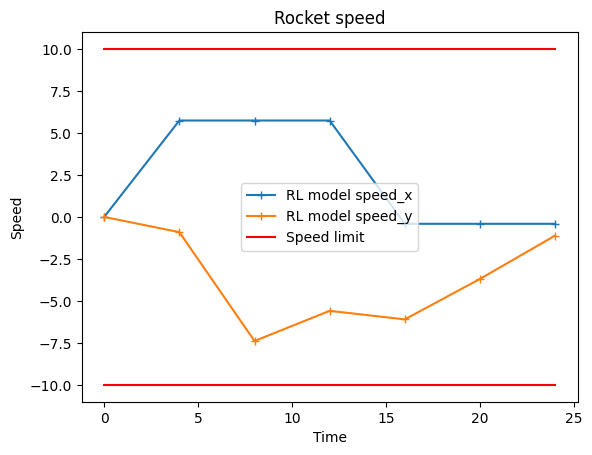

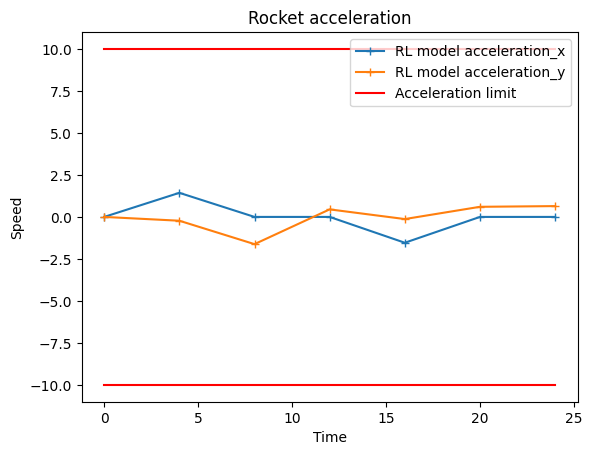

In [11]:
plot_reward_rocket_2agents(env)

plt.plot(dt[["time"]], dt[["speed_x"]], "+-", label = "RL model speed_x")
plt.plot(dt[["time"]], dt[["speed_y"]], "+-", label = "RL model speed_y")
plt.plot(dt[["time"]], np.array([-10]*len(dt[["time"]])), color ="red", label = "Speed limit" )
plt.plot(dt[["time"]], np.array([10]*len(dt[["time"]])), color ="red")
plt.title("Rocket speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.show()

plt.plot(dt[["time"]], dt[["acceleration_x"]], "+-", label = "RL model acceleration_x")
plt.plot(dt[["time"]], dt[["acceleration_y"]], "+-", label = "RL model acceleration_y")
plt.plot(dt[["time"]], np.array([-10]*len(dt[["time"]])), color ="red", label = "Acceleration limit" )
plt.plot(dt[["time"]], np.array([10]*len(dt[["time"]])), color ="red")
plt.title("Rocket acceleration")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.show()

## <span style="color:orange">Conclusion</span>

With our designed reward function and discretization settings, we provide a model capable of landing the rocket at the correct coordinates, with an appropriate angle and safe speed.
However, one of the main limitations of Q-learning is that it operates in a discrete state space, which can limit precision and scalability.
To overcome this limitation, we can replace the Q-table with a deep neural network, allowing us to approximate the Q-function in a continuous state space—a method known as Deep Q-Learning (DQN).